In [42]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
# get the toy dataset
from datasets import load_dataset
dataset = load_dataset("nschantz21/ms_marco_large_sample")

  0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
# how much data do you want to work with
little_dataset = dataset["train"][:500]

In [ ]:
dataset["train"][:500]

In [46]:
!git clone https://github.com/naver/splade.git

fatal: destination path 'splade' already exists and is not an empty directory.


In [47]:
pip install ./splade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./splade
  Preparing metadata (setup.py) ... done
  Created wheel for SPLADE: filename=SPLADE-2.1-py3-none-any.whl size=54632 sha256=e0715ceadd11fd187be915638be8e99e654eb377e42cb1175eb9d0053e2b0629
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgs8eu18/wheels/bb/3e/8d/57da6f0e8c25c0e78c690af020bf7f4bbd58deba82a9939983
Successfully built SPLADE
  Attempting uninstall: SPLADE
    Found existing installation: SPLADE 2.1
    Uninstalling SPLADE-2.1:
      Successfully uninstalled SPLADE-2.1


In [48]:
import numpy as np
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from splade.models.transformer_rep import Splade
from tqdm import tqdm

In [49]:
# set the dir for trained weights

##### v2
# model_type_or_dir = "weights/splade_max"
# model_type_or_dir = "weights/distilsplade_max"

### v2bis, directly download from Hugging Face
# model_type_or_dir = "naver/splade-cocondenser-selfdistil"
model_type_or_dir = "naver/splade-cocondenser-ensembledistil"

In [50]:
# loading model and tokenizer
model = Splade(model_type_or_dir, agg="max")
model.eval()
tokenizer = AutoTokenizer.from_pretrained(model_type_or_dir)
reverse_voc = {v: k for k, v in tokenizer.vocab.items()}

In [51]:
p_array_list = []
for out in tqdm(little_dataset["passage"]):
    pt = model(
        d_kwargs=tokenizer(
            out, return_tensors="pt"
            )
        )
    rep = pt["d_rep"].squeeze()
    # get the number of non-zero dimensions in the rep:
    col = torch.nonzero(rep).squeeze().cpu().tolist()

    # now let's inspect the bow representation:
    weights = rep[col].cpu().tolist()
    
    d = {k: v for k, v in zip(col, weights)}

    sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    bow_rep = []
    for k, v in sorted_d.items():
        bow_rep.append((k, reverse_voc[k], round(v, 2)))
    p_array_list.append(np.array(bow_rep))

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 500/500 [04:25<00:00,  1.88it/s]


In [52]:
condensed_p_array_list = [(p[:, 0].astype(int), ' '.join(p[:, 1]), p[:, 2].astype(float)) for p in p_array_list]

In [53]:
def get_vec(pos_arr, score_arr):
    z = np.zeros(len(tokenizer.vocab.items()))
    for i, k in enumerate(pos_arr):
        np.put(z, k, score_arr[i])
    return z

In [54]:
p_vec_list = [get_vec(p[0], p[2]) for p in condensed_p_array_list]

In [55]:
import datasets
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

#model.config = fm_config
#pipe = pipeline(model=model_type_or_dir)

# KeyDataset (only *pt*) will simply return the item in the dict returned by the dataset item
# as we're not interested in the *target* part of the dataset. For sentence pair use KeyPairDataset
q_array_list = []
for out in tqdm(little_dataset["query"]):
    #print(out)
    pt = model(
        d_kwargs=tokenizer(
            out, return_tensors="pt"
            )
        )
    rep = pt["d_rep"].squeeze()

    # get the number of non-zero dimensions in the rep:
    col = torch.nonzero(rep).squeeze().cpu().tolist()
    #print("number of actual dimensions: ", len(col))

    # now let's inspect the bow representation:
    weights = rep[col].cpu().tolist()
    d = {k: v for k, v in zip(col, weights)}
    sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    bow_rep = []
    for k, v in sorted_d.items():
        bow_rep.append((k, reverse_voc[k], round(v, 2)))
    q_array_list.append(np.array(bow_rep))

  0%|          | 0/500 [00:00<?, ?it/s]

In [56]:
condensed_q_array_list = [(q[:, 0].astype(int), ' '.join(q[:, 1]), q[:, 2].astype(float)) for q in q_array_list]

In [57]:
q_vec_list = [get_vec(q[0], q[2]) for q in condensed_q_array_list]

In [102]:
# testing similarity
p_vec_mat = np.vstack(p_vec_list)

In [146]:
def bifrication_similarity(passages, query, passage_idx, threshold=100):
    if len(passages) < threshold:
        return passages, passage_idx
    midpoint = len(passages) // 2
    half1 = passages[:midpoint]
    half2 = passages[midpoint:]
    half1_similarity = half1.max(axis=0)@query
    half2_similarity = half2.max(axis=0)@query
    if half1_similarity > half2_similarity:
        return bifrication_similarity(half1, query, passage_idx[:midpoint], threshold)
    else:
        return bifrication_similarity(half2, query, passage_idx[midpoint:], threshold)

In [147]:
results = 0
for i, q in enumerate(q_vec_list):
    res = bifrication_similarity(
        p_vec_mat, 
        q, 
        [i for i in range(len(p_vec_list))], 
        10)
    if i in res[1]:
        results+=1
print(results)

467


using the mean the MRR@10 was 67   
Using the max, the MRR@10 was 93.4 - not bad  

In [148]:
results / 500

0.934

# Clustering To Try
* Spectral Clustering (Recursive)
* Agglomerative Clustering
    * Ward Distance
* Bisecting K-Means


In [58]:
# create an average of the scores at each node


In [60]:
from sklearn.cluster import SpectralClustering

In [61]:
# the default k-means label assignment didn't work well
number_clusters = 20
clustering = SpectralClustering(n_clusters=number_clusters, 
                                assign_labels="discretize",
                                n_neighbors=number_clusters)

In [62]:
clustering.fit(p_vec_list)

SpectralClustering(assign_labels='discretize', n_clusters=20, n_neighbors=20)

In [63]:
from collections import Counter

In [64]:
Counter(clustering.labels_)

Counter({15: 241,
         8: 28,
         9: 45,
         13: 10,
         5: 16,
         3: 12,
         12: 26,
         18: 3,
         7: 9,
         2: 9,
         4: 6,
         11: 23,
         10: 5,
         1: 34,
         0: 10,
         16: 10,
         14: 7,
         17: 4,
         6: 2})

In [70]:
subset = np.array(p_vec_list)[clustering.labels_ == 15]

In [79]:
subset.mean(axis=0)

(30522,)

In [71]:
from math import floor, sqrt

In [72]:
number_sub_clusters = floor(sqrt(len(subset)))
sub_clusters = SpectralClustering(
    n_clusters=number_sub_clusters,
    assign_labels="discretize",
    n_neighbors=number_sub_clusters).fit(subset)

In [74]:
Counter(sub_clusters.labels_)

Counter({13: 216,
         3: 2,
         7: 2,
         8: 2,
         5: 2,
         4: 2,
         1: 2,
         2: 1,
         11: 2,
         10: 2,
         9: 4,
         12: 1,
         0: 1,
         6: 2})

In [ ]:
# get clusters bigger than expected
max_cluster_size = number_clusters * 2
big_clusters = cluster_counts[cluster_counts > max_cluster_size]

In [80]:
from sklearn.metrics.pairwise import cosine_similarity

In [82]:
p_cosine_similarity_matrix = cosine_similarity(np.array(p_vec_list))

In [83]:
p_dist = 1 - p_cosine_similarity_matrix

docs for the linkage matrix:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage


In [85]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(p_dist) #define the linkage_matrix using ward clustering pre-computed distances

In [87]:
import matplotlib.pyplot as plt

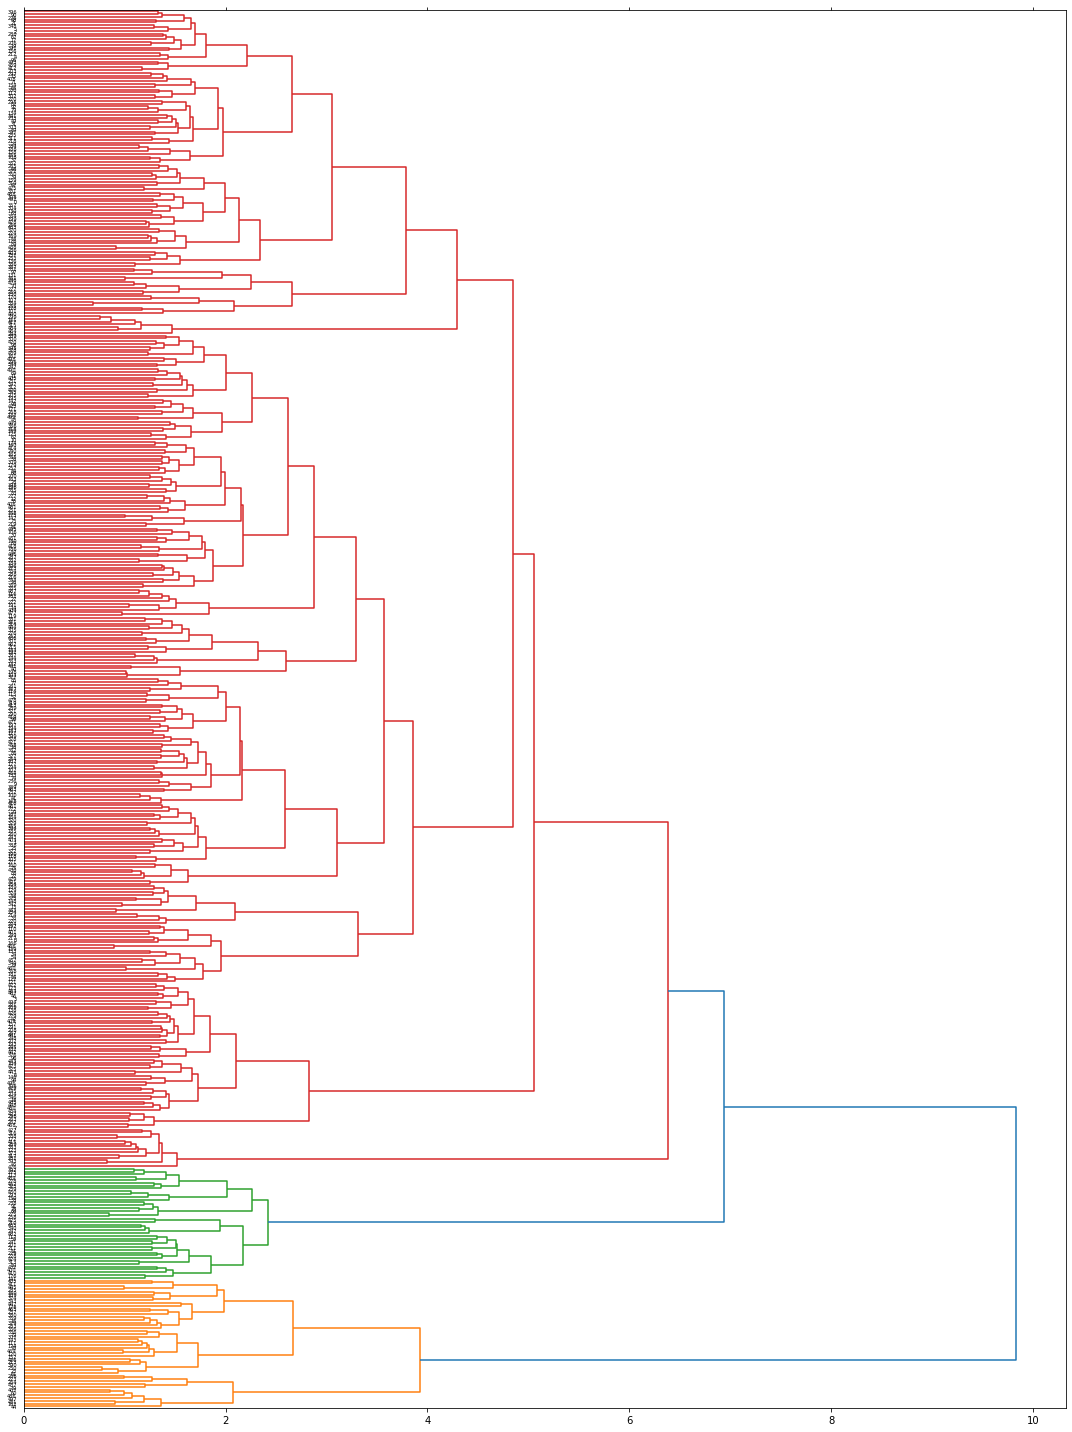

In [89]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [90]:
linkage_matrix

array([[2.55000000e+02, 3.84000000e+02, 6.88047874e-01, 2.00000000e+00],
       [1.51000000e+02, 2.99000000e+02, 7.58710869e-01, 2.00000000e+00],
       [2.30000000e+01, 2.50000000e+02, 7.71809142e-01, 2.00000000e+00],
       ...,
       [8.54000000e+02, 9.95000000e+02, 6.37924425e+00, 4.14000000e+02],
       [9.76000000e+02, 9.96000000e+02, 6.94162633e+00, 4.54000000e+02],
       [9.92000000e+02, 9.97000000e+02, 9.83253303e+00, 5.00000000e+02]])

## Agglomerative Clustering



In [95]:
from sklearn.cluster import AgglomerativeClustering

In [96]:
clustering = AgglomerativeClustering(linkage="ward", n_clusters=floor(sqrt(len(p_array_list))))

In [97]:
clustering.fit(np.array(p_vec_list))

AgglomerativeClustering(n_clusters=22)

In [98]:
clustering.labels_

array([ 0,  6,  0,  6, 19,  0,  2,  2,  6,  0,  6,  6,  0,  5,  4,  0,  0,
        0,  2,  0, 20,  0, 17,  8, 21, 20,  9,  4, 10, 15,  6,  0, 13,  5,
        6,  8,  6,  0,  3,  2, 10,  6,  6, 20, 13, 19,  6,  0,  0,  0,  3,
        3,  6,  1,  6,  0, 15, 14,  5,  3, 13,  8,  3,  7,  3,  0, 10,  0,
        7,  6,  6,  0,  6, 14,  6, 17,  8,  3,  3,  0,  4, 14,  6, 16, 10,
        6,  0,  0, 17,  1, 11,  3,  0,  6,  2,  0,  0,  6,  6,  6,  6,  6,
       17, 10,  2, 20,  6,  0,  0,  8, 15,  8,  6,  3,  6,  6,  4,  3, 20,
        4,  8,  2,  6, 19,  8,  6,  1,  6,  6,  5,  7,  6, 10,  6,  0,  6,
        6,  0,  2, 18,  6,  3,  6,  8,  6,  2,  6, 14,  5, 10,  6, 12,  8,
       15,  6, 20,  6,  2,  0,  7, 17,  6, 13, 10, 20, 20, 15, 20,  8,  0,
        0,  6, 19,  2,  6, 14,  3,  6, 19,  6,  6, 15,  6, 10,  4, 20, 14,
        2,  0,  5, 20,  4, 10,  0,  6,  6,  6,  2, 10,  1, 10,  3,  2,  6,
        2,  6,  0,  0,  2,  2,  6,  3, 19,  8,  5, 10,  9, 15,  0, 14,  4,
        2,  4, 13,  1,  3